In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
import time
import pandas as pd
import requests
import re

## Scraping angel.co

In [ ]:
# There is a horrible "load more" button. This makes sure, the entire page is loaded - up to 400 entries
def load_pages():
    try:
        time.sleep(5)
        while True:
            button = driver.find_element_by_class_name('more')
            driver.execute_script("arguments[0].scrollIntoView(true)", button)
            button.click()
            time.sleep(1)
    except:
        pass

# This extracts all the info that is in the list & puts it into a dict
def get_startup_info():
    wanted_stuff = ['name', 'pitch', 'location','joined', 'website', 'market', 'company_size', 'stage', 'raised', 'company_size']
    all_startups = []
    startup_list = driver.find_elements_by_class_name('startup')
    for startup in startup_list:
        temp = {}
        for ws in wanted_stuff:
            temp[ws] = startup.find_element_by_class_name(ws).text
        all_startups.append(temp)
    return all_startups

# This tries to narrow the search results down to <400 results (the maximun the site will show per search) by adjusting the min/max bracket accordingly. 
# It is SLOW - only use when the search has more than 400 results in the first place
def get_everything(n):
    min_ = 10000
    max_ = 10000
    base_url = 'https://angel.co/companies?company_types[]=Startup&company_types[]=Private+Company&company_types[]=SaaS&company_types[]=Mobile+App&raised[min]='
    url = base_url+str(min_)+'&raised[max]='+str(max_)
    driver.get(url)
    count = driver.find_element_by_xpath('//*[@id="root"]/div[4]/div[2]/div/div[2]/div[2]/div[1]/div[1]').text.split()[0]
    count = int(count)
    all_startups =[]
    while max_ < n:        
        print(len(all_startups))
        if count < 400:
            min_ = max_+10
            max_ = max_*1.2
            driver.get(base_url+str(min_)+'&raised[max]='+str(max_))
            count = driver.find_element_by_xpath('//*[@id="root"]/div[4]/div[2]/div/div[2]/div[2]/div[1]/div[1]').text.split()[0]
            count = int(count)
            if count > 0:
                time.sleep(2)
                load_pages()
                all_startups.extend(get_startup_info())
        elif count > 400:
            max_ = min_*1.05
            driver.get(base_url+str(min_)+'&raised[max]='+str(max_)+str(min_)+'&raised[max]='+str(max_))
            count = driver.find_element_by_xpath('//*[@id="root"]/div[4]/div[2]/div/div[2]/div[2]/div[1]/div[1]').text.split()[0]
            count = int(count)
    return all_startups
        

In [ ]:
# this limits the search results by raised amount per company, finds all companies in the min/max-bracket
min_ = 500000000
max_ = 1000000000000
url = 'https://angel.co/companies?raised[min]='+str(min_)+'&raised[max]='+str(max_)

In [ ]:
driver = webdriver.Chrome()
driver.get(url)
time.sleep(5)
load_pages()

In [ ]:
#get all the info into dict
all_startups =[]
all_startups.extend(get_startup_info())

## clean, extend, sort

In [ ]:
# get dict into dataframe - there might be duplicates, the site appears to be rounding some of the min/max values...
df = pd.DataFrame(all_startups)
df.drop_duplicates()
df.to_csv('all_startups_raw.csv')
df.head()

In [ ]:
# The site gives a "location" for the company, which is sometimes a city, sometimes an area, sometimes a country. 
# This sorts everything. Input is a list of unique location names to reduce API load
def get_country(list_):
    import os
    api_key = os.environ['GMAP_API']
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    all_places=[]
    for place in list_:
        keys = {'address': place, 'key': api_key}
        this_address= requests.get(url,params=keys).json()
        this_place = {}
        try: 
            for res in this_address['results'][0]['address_components']:       
                if res['types'][0] == 'administrative_area_level_1':
                    this_place['state'] = res['long_name']
                if res['types'][0] == 'country':
                    this_place['country'] = res['long_name']
                this_place['location_'] = place
        except:
               pass
        all_places.append(this_place)
    return all_places

# this assigns country and state to the dataframe respectively
def assign_country(row):
    for place in all_places:
        try:
            if place['location_'] == row['location']:
                return pd.Series(place)
        except:
            pass

# The dataset is horrible, the funded amounts are in Dollar, Pound and Euro. This makes them int and calculates USD for each.
def get_currency(row):
    funding = row['raised']
    this_company={}
    this_company['raised_curr'] = re.findall(r'(^.*?)\d', funding)[0]
    this_company['raised_amnt'] = ''.join(re.findall(r'([\d]+)', funding))
    if this_company['raised_curr'] != '$':
        this_company['raised_amnt_orignal'] = this_company['raised_amnt']
        try:
            this_company['raised_amnt'] = get_usd(this_company['raised_amnt'], this_company['raised_curr'])
        except: 
            this_company['raised_amnt'] = 'ERROR'
            print(row['name'], funding)
    return pd.Series(this_company)

In [ ]:
#create a list of unique location names
loc_list = df['location'].tolist()
loc_list = list(set(loc_list))
#get country/state for each location
all_places = get_country(loc_list)
df = df.apply(assign_country, axis = 1).join(df)
# it creates a duplicate row, as my code is lazy there. Drop it.
del df['location_']

In [ ]:
# Looks legit
df.country.value_counts()

In [ ]:
# cool currency calculation
df = df.apply(get_currency, axis = 1).join(df)

In [ ]:
df.head()

In [ ]:
# I discovered a typo - Xiaomi is big, but not that big... Also, 'Costom' is not real and 'Meitu' is in there twice (sligthly different numbers though)
df = df[~(df['name'] == 'Costom ink')]
#df[df.name == 'Xiaomi']
df = df.set_value(135, 'raised_amnt', 40184700000)

In [ ]:
df[(df['name'] == 'Meitu')]

In [ ]:
# all columns are strings, this correct that
df['raised_amnt'] = df.raised_amnt.astype(int)
df['joined'] = pd.to_datetime(df['joined'], format='%b ’%y')
df.dtypes

In [ ]:
# save save save
df.to_csv('all_startups_unicorns.csv', encoding='utf-8', index=False)

## Let the plotting begin...

In [2]:
# Uncomment here if you do not start from top
df_unicorns = pd.read_csv('unicorns_markets_cleaned.csv')
df_runnerups = pd.read_csv('runnerups_cleaned_markets.csv')
df = pd.concat([df_unicorns, df_runnerups])
df_concat = pd.concat([df_unicorns.head(10), df_runnerups.head(10)])

In [3]:
import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

In [4]:
# This is the style I like. I actually wanted to use Futura and Mercury, but they don't seem to be available in Pandas
plt.rcdefaults()
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'patch.linewidth': 0.5,
    'patch.facecolor': '#C5C6C8',
    'patch.edgecolor': '#C5C6C8',
    'patch.antialiased': True,
    'font.size': 10.0,
    'font.family': 'Futura',
    'axes.facecolor': '#C5C6C8',
    'axes.edgecolor': '#C5C6C8',
    'axes.linewidth': '1',
    'axes.grid': False,
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'axes.labelcolor': 'black',
    'axes.axisbelow': True,
    'axes.prop_cycle': cycler('color', ['#002458', '#01388B', '#0474BC', '#009DE0', '#004318', '#016B29', '#6AAF21', '#BCCD02', '#013646', '#015764', '#017783', '#0198A1', '#570B56', '#7A0B69', '#E30059', '#700D10', '#940D13', '#EF7F01', '#FDCC03']),
    'xtick.color': 'black',
    'xtick.direction': 'out',
    'ytick.color': 'black',
    'ytick.direction': 'out',
    'grid.color': 'C5C6C8',
    'grid.linestyle': '-',
    'figure.facecolor': 'C5C6C8',
    'savefig.bbox' : 'tight'
})

In [5]:
# Plot top 10 unicorns - companies with a market cap / valuation of more than USD 1 bln and the top 10 runner ups
df_unicorns = df[df['raised_amnt'] > 1000000000].sort_values(by='raised_amnt', ascending= False)
df_runnerups = df[df['raised_amnt'] < 1000000000].sort_values(by='raised_amnt', ascending= False)

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


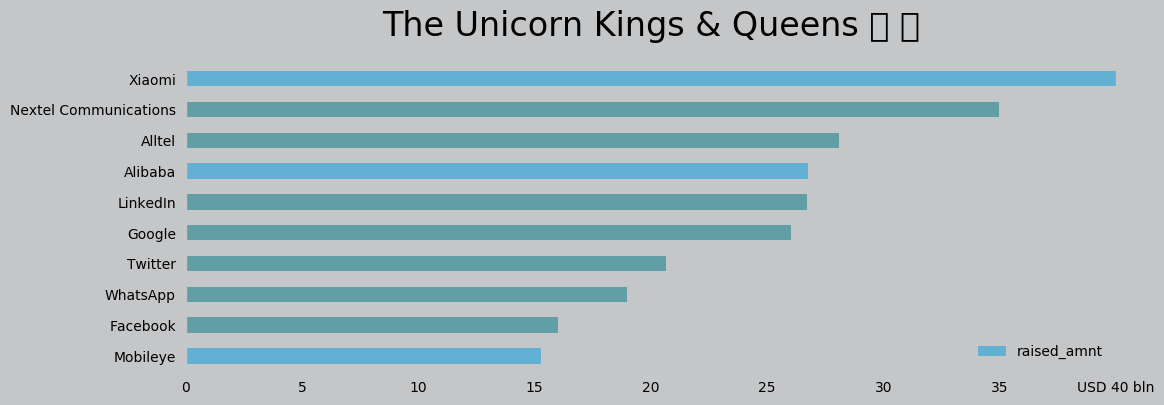

In [6]:
def get_color(country):
    if country != 'United States': 
        return '#009DE0'
    else:
        return '#017783'
bar_colors = [get_color(country) for country in df_unicorns.country.head(10)]
bar_colors = bar_colors[::-1]

from matplotlib.ticker import FuncFormatter
def blns(value, pos):
    blns = int(value / 1000000000)
    if blns > 35:
        return "USD {} bln".format(blns)
    else:
        return "{}".format(blns)
formatter = FuncFormatter(blns)

ax = df_unicorns.head(10).sort_values(by='raised_amnt', ascending= True).plot(x='name', y='raised_amnt', color = bar_colors, kind='barh', figsize=(12,4), alpha = 0.5)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
ax.set_title ("The Unicorn Kings & Queens 🦄 👑", pad=20,fontsize=24)
ax.set_xlim([0,40000000000])
ax.xaxis.set_major_formatter(formatter)
#ax.set_xticklabels([0,10,20,30, 40, 50, 60, '70 years'])
plt.savefig("1.pdf", facecolor = ax.get_facecolor())
plt.savefig("1.png", facecolor = ax.get_facecolor())
plt.show()

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


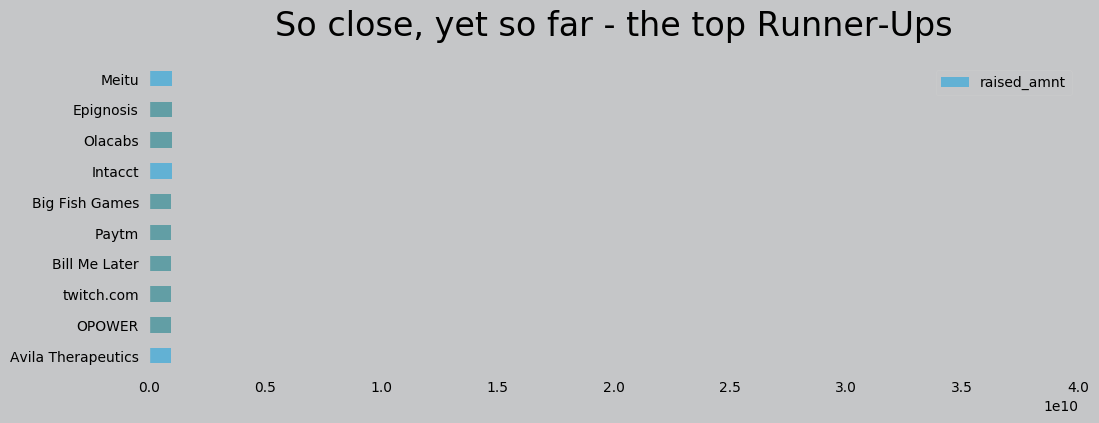

In [14]:
def get_color(country):
    if country != 'United States': 
        return '#009DE0'
    else:
        return '#017783'
bar_colors = [get_color(country) for country in df_unicorns.country.head(10)]
bar_colors = bar_colors[::-1]


ax = df_runnerups.head(10).sort_values(by='raised_amnt', ascending= True).plot(x='name', y='raised_amnt', kind='barh', figsize=(12,4), color = bar_colors, alpha = 0.5)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
ax.set_title ("So close, yet so far - the top Runner-Ups", pad=20,fontsize=24)
ax.set_xlim([0,40000000000])
plt.savefig("2.pdf", facecolor = ax.get_facecolor())
plt.savefig("2.png", facecolor = ax.get_facecolor())
plt.show()

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


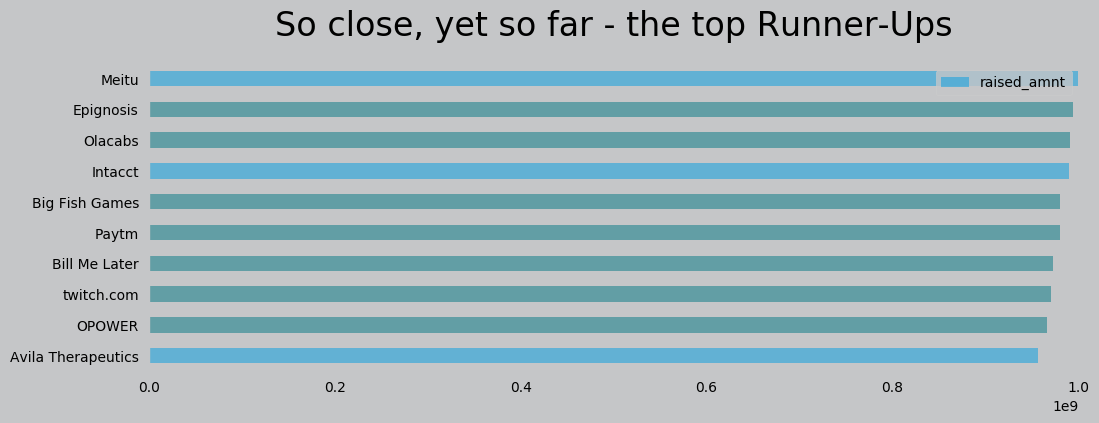

In [15]:
def get_color(country):
    if country != 'United States': 
        return '#009DE0'
    else:
        return '#017783'
bar_colors = [get_color(country) for country in df_unicorns.country.head(10)]
bar_colors = bar_colors[::-1]

ax = df_runnerups.head(10).sort_values(by='raised_amnt', ascending= True).plot(x='name', y='raised_amnt', kind='barh', figsize=(12,4), color = bar_colors, alpha = 0.5)
ax.tick_params(which='both', left=False, bottom=False)
ax.set_title ("So close, yet so far - the top Runner-Ups", pad=20,fontsize=24)
ax.yaxis.label.set_visible(False)
ax.set_xlim([0,1000000000])
plt.savefig("3.pdf", facecolor = ax.get_facecolor())
plt.savefig("3.png", facecolor = ax.get_facecolor())
plt.show()

In [16]:
df_concat = df_concat.fillna('United States')

In [17]:
df_concat = df_concat.sort_values(by='raised_amnt', ascending= True)

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


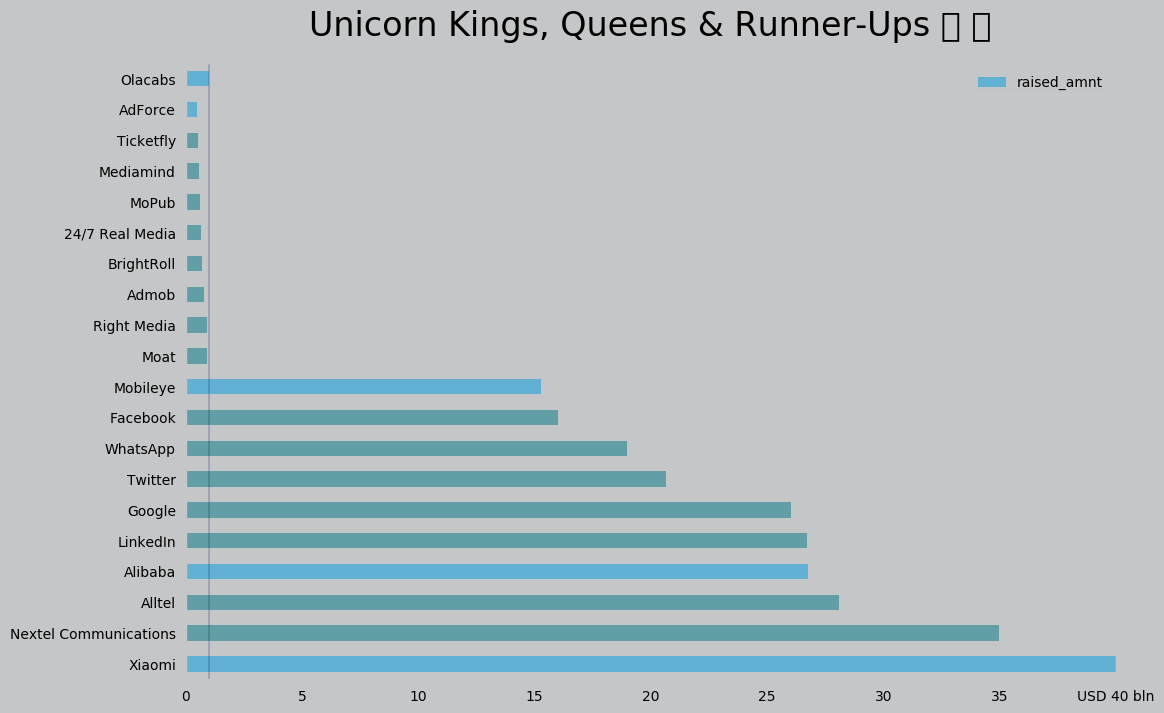

In [7]:
def get_color(country):
    if country != 'United States': 
        return '#009DE0'
    else:
        return '#017783'
bar_colors = [get_color(country) for country in df_concat.country]
#bar_colors = bar_colors[::-1]

from matplotlib.ticker import FuncFormatter
def blns(value, pos):
    blns = int(value / 1000000000)
    if blns == 40 or blns == 1:
        return "USD {} bln".format(blns)
    else:
        return "{}".format(blns)
formatter = FuncFormatter(blns)

ax = df_concat.plot(x='name', y='raised_amnt', color = bar_colors, kind='barh', figsize=(12,8), alpha = 0.5)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.label.set_visible(False)
ax.set_title ("Unicorn Kings, Queens & Runner-Ups 🦄 👑", pad=20,fontsize=24)
ax.set_xlim([0,40000000000])
ax.xaxis.set_major_formatter(formatter)
ax.axvline(1000000000, alpha = 0.2)
plt.savefig("1-1.pdf", facecolor = ax.get_facecolor())
#plt.savefig("1.png", facecolor = fig.get_facecolor())
plt.show()

In [ ]:
df_concat

In [ ]:
# Where do these companies come from? Where do the runner-ups come from, those companies with a valuation of USD 500-999 mio

# two pie

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


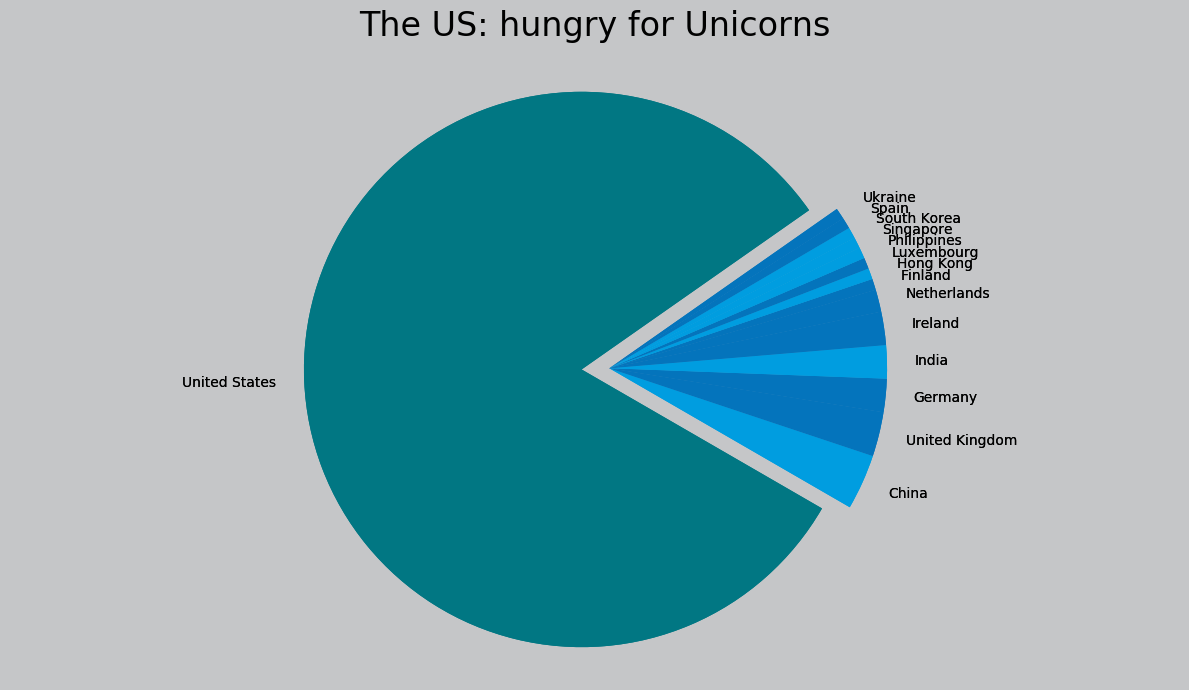

In [20]:
#bar_colors = ['#002458', '#01388B', '#0474BC', '#0474BC', '#01388B', '#0474BC', '#0474BC', '#0474BC', '#01388B', '#0474BC', '#01388B', '#01388B', '#01388B', '#0474BC', '#0474BC']
bar_colors = ['#017783', '#009DE0', '#0474BC', '#0474BC', '#009DE0', '#0474BC', '#0474BC', '#0474BC', '#009DE0', '#0474BC', '#009DE0', '#009DE0', '#009DE0', '#0474BC', '#0474BC']
explode = [0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
ax = df_unicorns.groupby('country').count().sort_values(by='joined', ascending = False).joined.plot(kind='pie', startangle = 35, explode = explode, figsize=(12,7), y='joined', label='country', colors = bar_colors)
plt.axis('equal')
plt.tight_layout()
ax.set_title ("The US: hungry for Unicorns", pad=20,fontsize=24)
ax.yaxis.label.set_visible(False)
plt.savefig("4.pdf", facecolor = ax.get_facecolor())
plt.savefig("4.png", facecolor = ax.get_facecolor())
plt.show()

In [3]:
df_runnerups.groupby('country').count().sort_values(by='joined', ascending = False).joined

country
United States     116
United Kingdom      7
China               3
India               3
Canada              2
Germany             2
Australia           1
Greece              1
Monaco              1
Singapore           1
Spain               1
Switzerland         1
Turkey              1
Name: joined, dtype: int64

/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


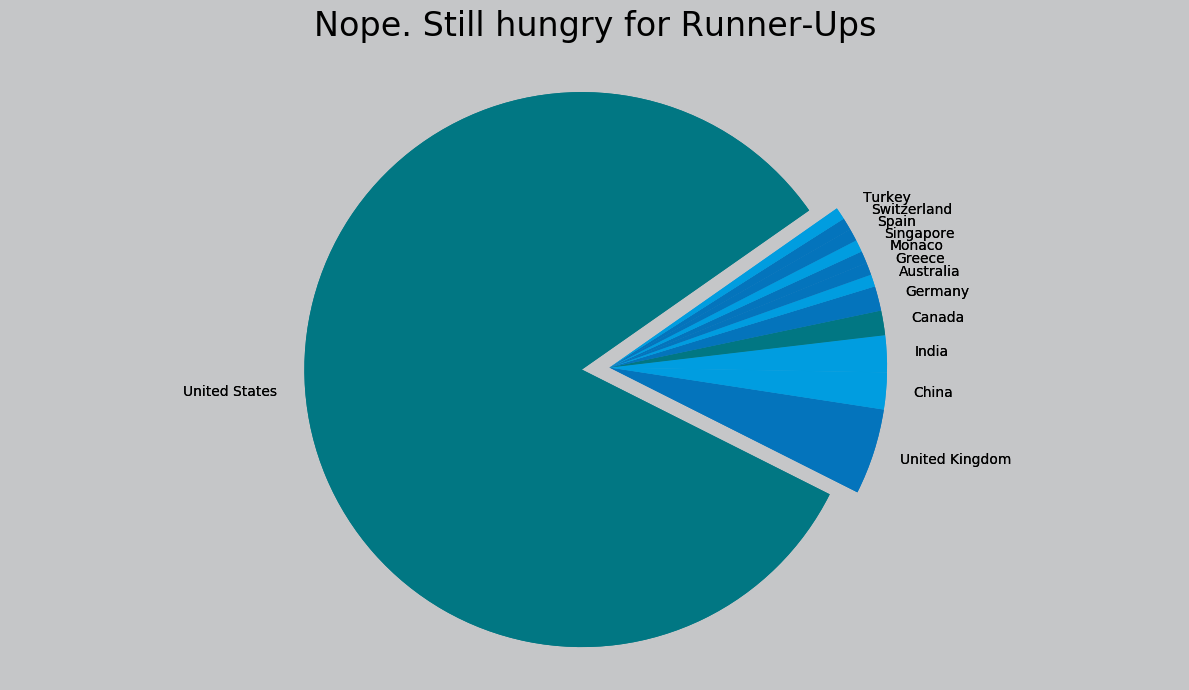

In [23]:
#bar_colors = ['#002458', '#0474BC', '#01388B', '#01388B','#002458', '#0474BC', '#009DE0', '#0474BC', '#0474BC', '#01388B', '#0474BC', '#0474BC', '#01388B']
bar_colors = ['#017783', '#0474BC', '#009DE0', '#009DE0','#017783', '#0474BC', '#009DE0', '#0474BC', '#0474BC', '#009DE0', '#0474BC', '#0474BC', '#009DE0']
explode = [0.1,0,0,0,0,0,0,0,0,0,0,0,0]
ax = df_runnerups.groupby('country').count().sort_values(by='joined', ascending = False).joined.plot(kind='pie', startangle = 35, explode = explode, figsize=(12,7), y='raised_amnt', label='country', colors = bar_colors)
plt.axis('equal')
plt.tight_layout()
ax.set_title ("Nope. Still hungry for Runner-Ups", pad=20,fontsize=24)
ax.yaxis.label.set_visible(False)
plt.savefig("5.pdf", facecolor = ax.get_facecolor())
plt.savefig("5.png", facecolor = ax.get_facecolor())
plt.show()

In [5]:
# A closer look at the US: How big is California's startup industrie really (Spoiler: it's yuuuge)
state_raise = [df[df.state == 'California'].raised_amnt.sum(), df[~(df.state == 'California') & (df.country == 'United States')].raised_amnt.sum(), df[~(df.country == 'United States')].raised_amnt.sum()]

In [6]:
state_raise

[368983862689, 230816387842, 322064844294]

In [25]:
df[~(df.state == 'California') & (df.country == 'United States')]

,raised_curr,raised_amnt,country,state,company_size,joined,location,market,name,pitch,raised,stage,website
1,$,35000000000,United States,Kansas,-,2012-01-01,Overland Park,Advertising,Nextel Communications,NaN,"$35,000,000,000",Acquired,nextel.com
2,$,28100000000,United States,Arkansas,-,2012-01-01,Little Rock,Advertising,Alltel,NaN,"$28,100,000,000",Acquired,alltel.com
10,$,14900000000,United States,Illinois,NaN,2016-02-01,Chicago,Hardware,Cyberdyne Communcations,wholesale global communcations,"$14,900,000,000",Seed,cynet-internet.com
26,$,6592450941,United States,New York,-,2012-01-01,New York City,E-Commerce,Verizon,NaN,"$6,592,450,941",-,verizon.com
27,$,6400000000,United States,Washington,-,2012-01-01,Redmond,Social,aQuantive,NaN,"$6,400,000,000",Acquired,aquantive.com
30,$,5700000000,United States,Massachusetts,201-500,2012-01-01,Acton,Hardware,Arrowpoint,Equipment that speeds delivery of Web content ...,"$5,700,000,000",IPO,arrowpoint.com
32,$,5155000000,United States,New York,51-200,2013-12-01,New York City,Social,WeWork,NaN,"$5,155,000,000",Seed,wework.com
33,$,5040000000,United States,Texas,-,2012-01-01,Dallas,Media,Broadcast.com,NaN,"$5,040,000,000",Acquired,broadcast.com
37,$,4500000000,United States,Pennsylvania,201-500,2012-07-01,Pittsburgh,Hardware,FORE Systems,A computer network switching equipment company,"$4,500,000,000",Acquired,NaN
43,$,4000000000,United States,New York,-,2012-01-01,New York City,Media,Marvel Entertainment,NaN,"$4,000,000,000",Acquired,marvel.com


/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


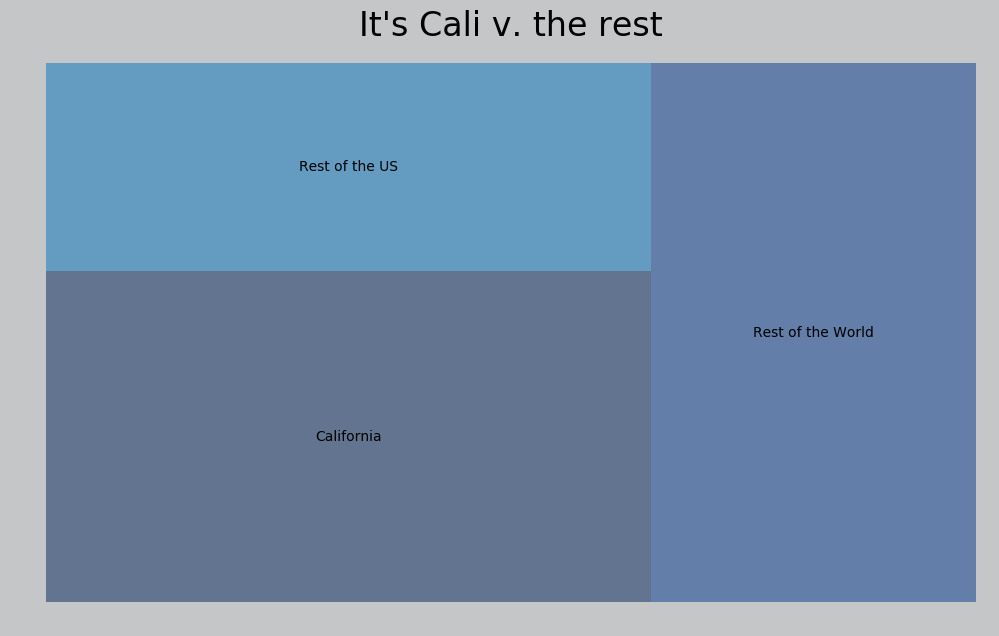

In [26]:
import squarify
fig, ax = plt.subplots(figsize=(12,7))
colors = ['#002458', '#0474BC', '#01388B'] #for some reason, it is ignoring my color choice. Will use illustrator
ax = squarify.plot(state_raise, label = ['California', 'Rest of the US', 'Rest of the World'], color = colors, alpha=0.5 )
plt.axis('off')
ax.set_title ("It's Cali v. the rest", pad=20,fontsize=24)
ax.set_prop_cycle('color', colors)
plt.savefig("6.pdf", facecolor = ax.get_facecolor())
plt.savefig("6.png", facecolor = ax.get_facecolor())
plt.show()

In [27]:
# Which industries are dominant?

# two scatter (industrie on x, stages on y, funding in bubblesize)

In [28]:
# clean the 'market' columns outside of pandas a bit up... it was very messy
df_unicorns.to_csv('unicorns_raw.csv')
df_runnerups.to_csv('runnerups_raw.csv')

In [29]:
df_unicorns = pd.read_csv('unicorns_markets_cleaned.csv')
df_runnerups = pd.read_csv('runnerups_cleaned_markets.csv')
df = pd.concat([df_unicorns, df_runnerups])
df_concat = pd.concat([df_unicorns.head(10), df_runnerups.head(10)])


/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


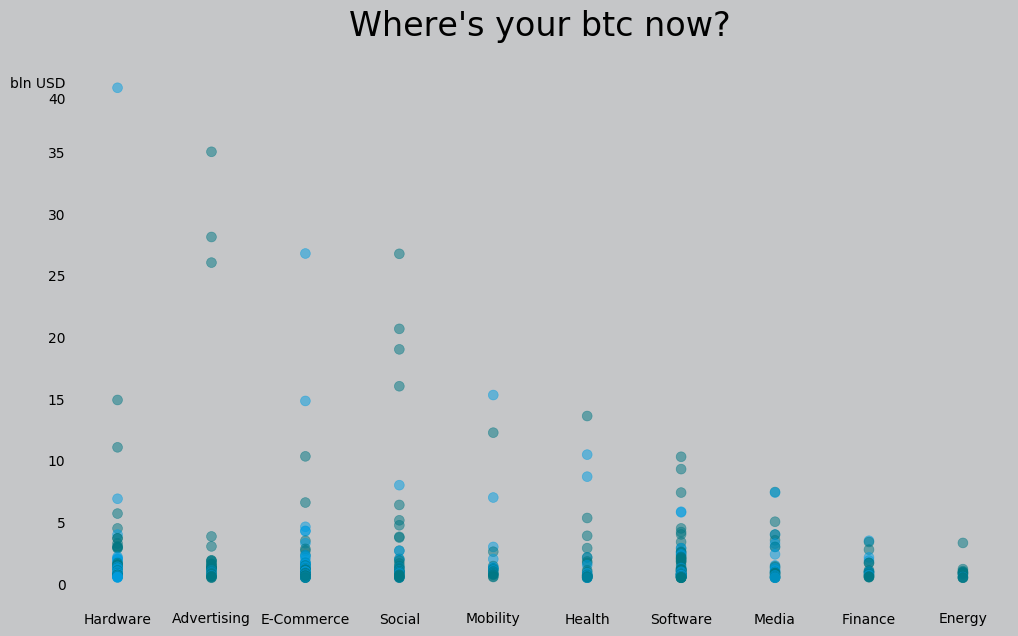

In [34]:
def get_color(country):
    if country != 'United States': 
        return '#009DE0'
    else:
        return '#017783'
scatter_colors = [get_color(country) for country in df_unicorns.country]

def blns(value, pos):
    blns = int(value / 1000000000)
    if blns == 40 or blns == 1:
        return "bln USD\n{}".format(blns)
    else:
        return "{}".format(blns)
formatter = FuncFormatter(blns)


fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(x=df.market, y=df.raised_amnt.astype(int), s=50, alpha=0.5, color=scatter_colors)
#plt.gca().invert_yaxis()
ax.set_title ("Where's your btc now?", pad=20,fontsize=24)
ax.tick_params(which='both', left=False, bottom=False)
ax.yaxis.set_major_formatter(formatter)
plt.savefig("7.pdf", facecolor = ax.get_facecolor())
plt.savefig("7.png", facecolor = ax.get_facecolor())
plt.show()

In [31]:
df['dotcom'] = df.website.str.contains(r'(.com)', na=False)

/home/jls/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


/home/jls/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Futura'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


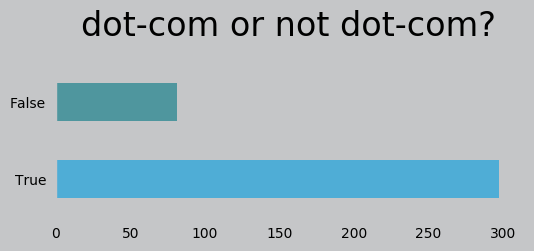

In [33]:
ax = df.dotcom.value_counts().plot(kind='barh', figsize=(6,2), color = ['#009DE0', '#017783'], alpha = 0.6, stacked = True)
ax.yaxis.label.set_visible(False)
ax.set_title ("dot-com or not dot-com?", pad=20,fontsize=24)
ax.tick_params(which='both', left=False, bottom=False)
plt.savefig("8.pdf", facecolor = ax.get_facecolor())
plt.savefig("8.png", facecolor = ax.get_facecolor())
plt.show()
